# U-2-NETp STEP-BY-STEP DEMONSTRATION

**Using U-2-NETp for :**
 - **Background Removal**
 - **Bounding Box Creation**
 - **Salient Feature Highlighting**


 U-2-NET Paper: [U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/abs/2005.09007)

 Original Repo: [U-2-Net Github repo](https://github.com/NathanUA/U-2-Net)

References: X. Qin, Z. Zhang, C. Huang, M. Dehghan, O. R. Zaiane, and M. Jagersand, “U2-net: Going deeper with nested u-structure for salient object
detection,” Pattern Recognition, vol. 106, p. 107404, 2020

In [1]:
# make sure cloned code is saved in content
%cd /content

# verify CUDA
!/usr/local/cuda/bin/nvcc --version

# clone modified version of U-2-Net
!git clone https://github.com/shreyas-bk/U-2-Net

# make images directory (to store imput images) and results (to store output images) in U-2-Net folder
%cd /content/U-2-Net
print('making images directory')
!mkdir images
print('making results directory')
!mkdir results

#import required modules
print('importing...')
from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2
print('Done!')

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Cloning into 'U-2-Net'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 502 (delta 2), reused 0 (delta 0), pack-reused 496
Receiving objects: 100% (502/502), 12.38 MiB | 6.33 MiB/s, done.
Resolving deltas: 100% (226/226), done.
/content/U-2-Net
making images directory
making results directory
importing...
Done!


# Make sure runtype is GPU
**Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU**

In [2]:
# change to images directory to upload image files
%cd /content/U-2-Net/images
uploaded = files.upload()

# change back to U-2-Net directory
%cd /content/U-2-Net

/content/U-2-Net/images


Saving U_2_NETP_IMAGE3.jpg to U_2_NETP_IMAGE3.jpg
/content/U-2-Net


In [3]:
# run the test script, and outputs are saved to results folder
!python -W ignore u2net_test.py

['/content/U-2-Net/images/U_2_NETP_IMAGE3.jpg']
inferencing: U_2_NETP_IMAGE3.jpg


In [4]:
# get the names of the images that were uploaded, removing .jpg
image_dir = os.path.join(os.getcwd(), 'images')
names = [name[:-4] for name in os.listdir(image_dir)]
names

['U_2_NETP_IMAGE3']

In [5]:
# this notebook only uses the first of the uploaded images
name = names[0]
name

'U_2_NETP_IMAGE3'

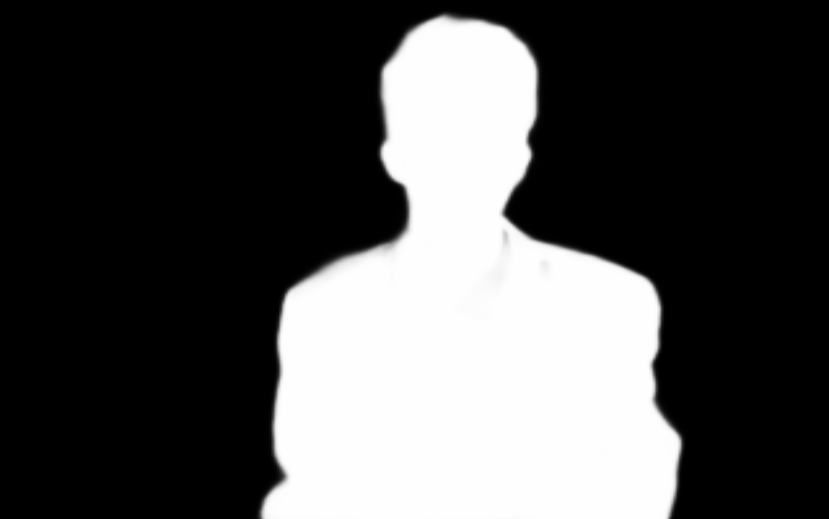

In [6]:
# display result that U-2-Net created
output = load_img('/content/U-2-Net/results/'+name+'.png')
display(output)

# BACKGROUND REMOVAL

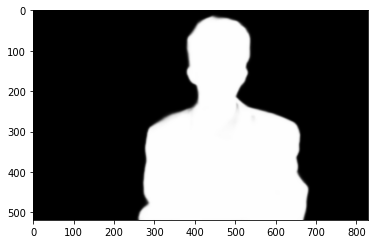

In [7]:
# convert output to numpy array and rescale(255 for RBG images)
RESCALE = 255
out_img = img_to_array(output)
out_img /= RESCALE
import matplotlib.pyplot as plt
plt.imshow(out_img)

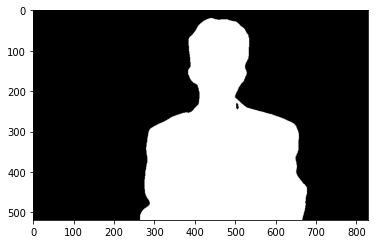

In [8]:
# define the cutoff threshold below which, background will be removed.
THRESHOLD = 0.9

# refine the output
out_img[out_img > THRESHOLD] = 1
out_img[out_img <= THRESHOLD] = 0
plt.imshow(out_img)

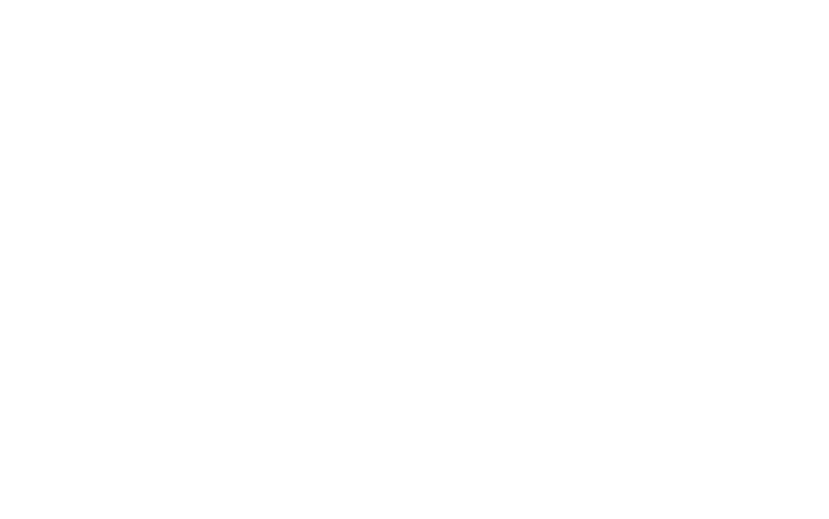

In [9]:
# convert the rbg image to an rgba image and set the zero values to transparent
shape = out_img.shape
a_layer_init = np.ones(shape = (shape[0],shape[1],1))
mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
a_layer = mul_layer*a_layer_init
rgba_out = np.append(out_img,a_layer,axis=2)
display(Img.fromarray((rgba_out*RESCALE).astype('uint8'), 'RGBA'))

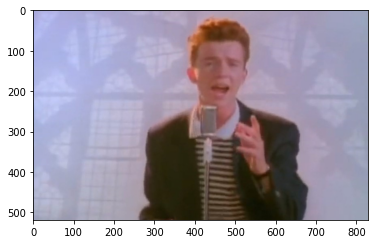

In [10]:
# load and convert input to numpy array and rescale(255 for RBG images)
input = load_img('/content/U-2-Net/images/'+name+'.jpg')
inp_img = img_to_array(input)
inp_img /= RESCALE
plt.imshow(inp_img)

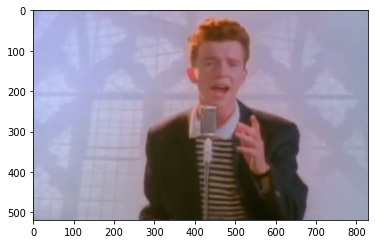

In [11]:
# since the output image is rgba, convert this also to rgba, but with no transparency
a_layer = np.ones(shape = (shape[0],shape[1],1))
rgba_inp = np.append(inp_img,a_layer,axis=2)
plt.imshow(rgba_inp)

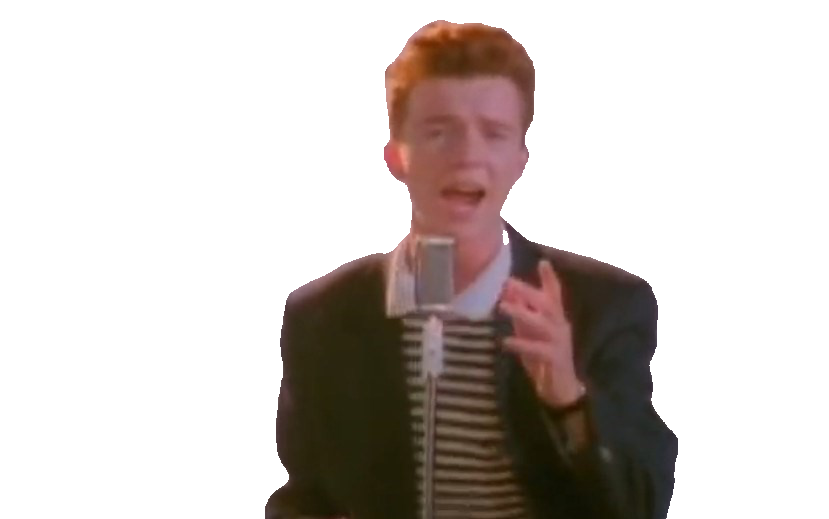

In [12]:
# simply multiply the 2 rgba images to remove the backgound
rem_back = (rgba_inp*rgba_out)
rem_back_scaled = Img.fromarray((rem_back*RESCALE).astype('uint8'), 'RGBA')
display(rem_back_scaled)
# --same, but using cv2--
#rem_back_cv = rem_back[:,:,[2,1,0,3]]
#from google.colab.patches import cv2_imshow
#cv2_imshow(rem_back_cv*RESCALE)

In [13]:
# save the resulting image to colab
rem_back_scaled.save(name+'_background_removed.png')

In [14]:
# download the result
files.download('/content/U-2-Net/'+name+'_background_removed.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# BOUNDING BOX CREATION

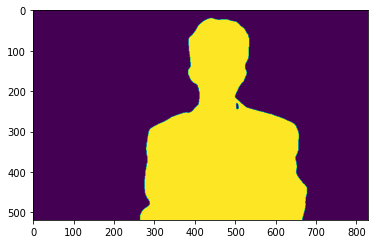

In [15]:
# select a layer(can be 0,1 or 2) for bounding box creation and salient map
LAYER = 2
out_layer = out_img[:,:,LAYER]
plt.imshow(out_layer)

In [16]:
# find the list of points where saliency starts and ends for both axes
x_starts = [np.where(out_layer[i]==1)[0][0] if len(np.where(out_layer[i]==1)[0])!=0 else out_layer.shape[0]+1 for i in range(out_layer.shape[0])]
x_ends = [np.where(out_layer[i]==1)[0][-1] if len(np.where(out_layer[i]==1)[0])!=0 else 0 for i in range(out_layer.shape[0])]
y_starts = [np.where(out_layer.T[i]==1)[0][0] if len(np.where(out_layer.T[i]==1)[0])!=0 else out_layer.T.shape[0]+1 for i in range(out_layer.T.shape[0])]
y_ends = [np.where(out_layer.T[i]==1)[0][-1] if len(np.where(out_layer.T[i]==1)[0])!=0 else 0 for i in range(out_layer.T.shape[0])]

# get the starting and ending coordinated for the box
startx = min(x_starts)
endx = max(x_ends)
starty = min(y_starts)
endy = max(y_ends)

# show the resulting coordinates
start = (startx,starty)
end = (endx,endy)
start,end

((265, 20), (677, 518))

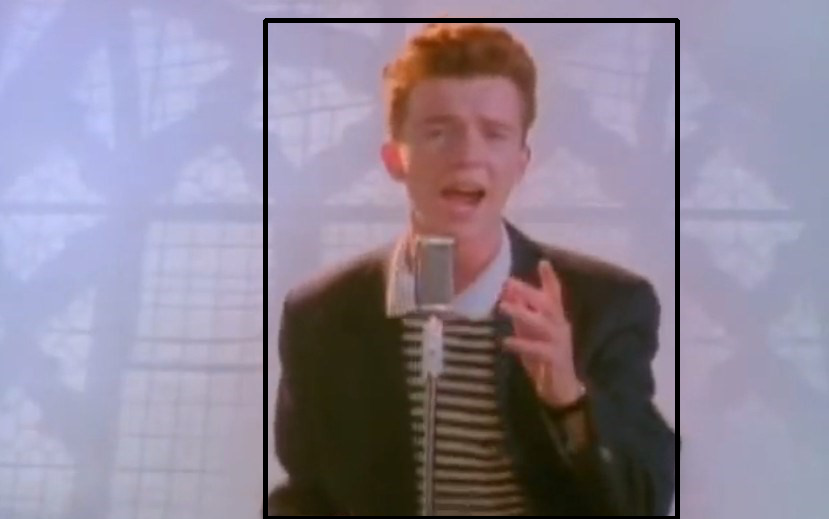

In [17]:
# create the bounding box using cv2
COLOR = (0, 0, 0)
THICKNESS = 4
box_img = inp_img.copy()
box_img *= RESCALE
box_img = cv2.rectangle(box_img, start, end, COLOR, THICKNESS)
box_img_scaled = Img.fromarray(box_img.astype('uint8'), 'RGB')
display(box_img_scaled)

In [18]:
# save the resulting image to colab
box_img_scaled.save(name+'_bounding_box.png')

In [19]:
# download the result
files.download('/content/U-2-Net/'+name+'_bounding_box.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

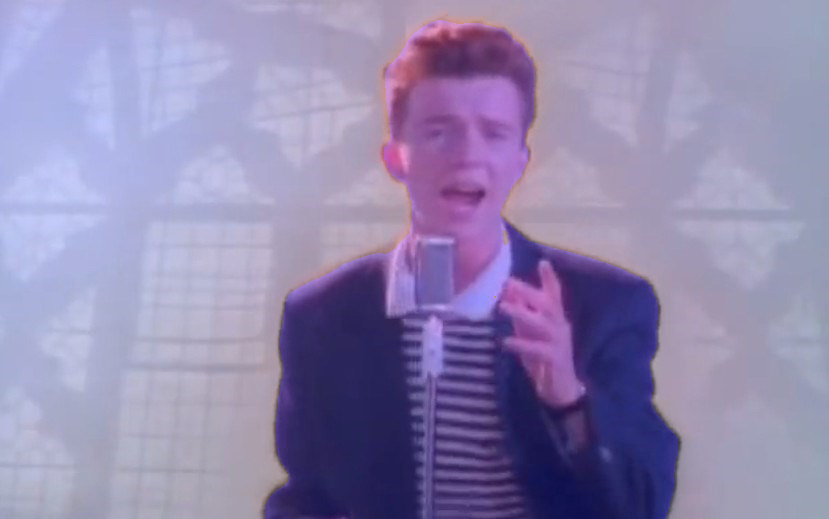

In [20]:
# set the salient shift value and add it to a layer of the input image
SAL_SHIFT = 75
sal_img = inp_img.copy()
sal_img*=RESCALE
add_layer = out_img.copy()
add_layer[add_layer==1] = SAL_SHIFT
sal_img[:,:,LAYER] += add_layer[:,:,LAYER]
sal_img_scaled = Img.fromarray(sal_img.astype('uint8'), 'RGB')
display(sal_img_scaled)

In [21]:
# save the resulting image to colab
sal_img_scaled.save(name+'_salient_map.png')

In [22]:
# download the result
files.download('/content/U-2-Net/'+name+'_salient_map.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>